In [2]:
import sys
sys.path.append("../lib/")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, StandardScaler

from sklearn.decomposition import PCA, NMF
from sklearn.cluster import FeatureAgglomeration
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, l1_min_c, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectFromModel

/home/daniel/mambaforge/envs/raman_ml/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
from raman_lib.preprocessing import SavGolFilter, RangeLimiter, BaselineCorrector, PeakPicker
from raman_lib.misc import load_data
from raman_lib.crossvalidation import CrossValidator

In [4]:
data = load_data("../results/quality_control/L_540_2022_C_E_qc.csv")
data

,label,file,440.0,440.5,441.0,441.5,442.0,442.5,443.0,443.5,...,1805.5,1806.0,1806.5,1807.0,1807.5,1808.0,1808.5,1809.0,1809.5,1810.0
0,Control,/home/daniel/Raman_Daten/L-540_2022/Control/C2.49,21144.603516,21145.177734,21141.513672,21131.599609,21120.470703,21115.240234,21121.103516,21144.158203,...,6130.609863,6127.049316,6129.252930,6128.873535,6117.505859,6100.728027,6091.381836,6090.376465,6087.515625,6074.697266
1,Control,/home/daniel/Raman_Daten/L-540_2022/Control/C2.2,24565.566406,24440.099609,24309.644531,24174.353516,24043.277344,23927.326172,23829.269531,23749.289062,...,3631.689209,3622.919678,3623.137939,3624.281250,3618.023926,3609.669678,3612.567627,3623.730713,3627.421387,3614.033936
2,Control,/home/daniel/Raman_Daten/L-540_2022/Control/C2.28,13911.670898,13848.631836,13790.729492,13742.374023,13704.474609,13679.045898,13662.330078,13649.971680,...,2969.355957,2960.972168,2957.730713,2956.473389,2952.861572,2948.163086,2948.003174,2951.171875,2949.877930,2938.897705
3,Control,/home/daniel/Raman_Daten/L-540_2022/Control/C2.41,11807.129883,11788.761719,11775.951172,11766.423828,11756.272461,11743.598633,11728.326172,11710.676758,...,3092.745605,3084.047607,3084.255127,3090.730469,3097.800537,3102.405273,3105.736328,3107.947266,3104.629395,3094.199219
4,Control,/home/daniel/Raman_Daten/L-540_2022/Control/C3.75,12433.136719,12428.432617,12405.315430,12365.429688,12306.487305,12236.616211,12163.192383,12095.759766,...,2586.108398,2576.812500,2571.243408,2569.910889,2572.708984,2575.367432,2574.502441,2570.448975,2566.095215,2562.811035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,Etoposide,/home/daniel/Raman_Daten/L-540_2022/Etoposide/...,1705.850708,1704.834961,1702.136353,1697.925049,1693.361084,1689.570801,1686.694092,1684.512451,...,379.970520,382.493286,386.532593,389.179382,389.098755,386.762726,384.099670,382.043488,379.756775,376.492096
596,Etoposide,/home/daniel/Raman_Daten/L-540_2022/Etoposide/...,5258.229980,5260.072754,5265.291504,5272.294434,5278.858398,5282.749023,5283.154785,5279.097656,...,2010.950317,2014.541748,2015.504272,2013.233887,2008.590454,2004.280762,2001.807617,2001.402344,2002.772461,2005.169434
597,Etoposide,/home/daniel/Raman_Daten/L-540_2022/Etoposide/...,6118.257324,6108.251953,6103.568359,6103.503906,6106.661133,6110.168457,6111.169434,6108.247559,...,1368.642334,1372.099121,1372.514038,1370.289062,1366.546997,1362.255615,1357.718994,1354.340820,1354.057617,1355.484131
598,Etoposide,/home/daniel/Raman_Daten/L-540_2022/Etoposide/...,4488.493164,4491.041016,4494.679688,4498.824707,4503.024414,4507.029297,4510.768066,4513.976562,...,1841.452515,1838.885864,1837.142944,1836.446899,1837.767090,1840.137573,1840.917114,1837.812988,1831.623779,1826.118652


In [5]:
X = data.drop(columns=["label", "file"], errors="ignore")
wns = np.asarray(X.columns.astype(float))
X = np.asarray(X)
y = np.asarray(data.label)
y, y_key = pd.factorize(y)

In [6]:
X_orig = X.copy()
X = BaselineCorrector().fit_transform(X)

rl = RangeLimiter(lim=(450, 1670), reference=wns)
X = rl.fit_transform(X)
wns = wns[rl.lim_[0]:rl.lim_[1]]

X = SavGolFilter().fit_transform(X)

X = Normalizer().fit_transform(X)

In [83]:
clf = LGBMClassifier(random_state=2434, boosting_type="rf", colsample_bytree=0.2, subsample=0.8, subsample_freq=1, max_bin=10)

param_grid = {
   "max_depth": range(1, 11)
}

In [87]:

clf = LGBMClassifier(random_state=2434, max_depth=5, colsample_bytree=0.2, max_bin=10, n_estimators=50)

param_grid = {
   "learning_rate": np.linspace(0.01, 0.1, 10)
}


In [88]:

cv = CrossValidator(clf,
                    param_grid,
                    n_trials=3,
                    n_jobs=-1,
                    scoring="roc_auc",
                    feature_names=wns).fit(X, y)

          :   0%|          | 0/3 [00:00<?, ?it/s]

In [93]:
clf.__class__.__name__

'LGBMClassifier'

In [44]:
shap.dependence_plot("rank(1)", cv.shap_results_.values, cv.shap_results_.data, feature_names=cv.shap_results_.feature_names)

AttributeError: 'CrossValidator' object has no attribute 'shap_results_'

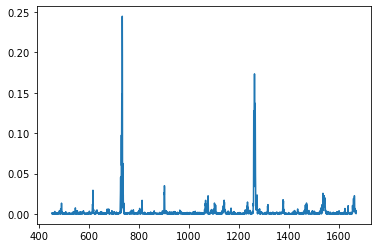

In [100]:
plt.plot(wns, np.mean(np.absolute(cv.shap_results_.values), axis=0))

In [89]:
pd.DataFrame(cv.ct_results_)

,train_score,test_score,fit_time,predict_time,p_value
0,1.00000,0.959833,1.745979,0.001937,2.518702e-45
1,0.99999,0.967722,1.749900,0.002058,3.252873e-50
2,1.00000,0.966667,1.670479,0.001439,4.442633e-46


In [90]:
pd.DataFrame(cv.cv_results_)

,param_learning_rate,train_score_0,test_score_0,train_score_1,test_score_1,train_score_2,test_score_2
0,0.01,0.993191,0.953222,0.993017,0.960778,0.991569,0.954111
1,0.02,0.996149,0.956278,0.995958,0.960944,0.995059,0.956500
2,0.03,0.998184,0.956667,0.998010,0.961889,0.997788,0.959833
3,0.04,0.999208,0.958944,0.999177,0.965167,0.999122,0.960167
4,0.05,0.999715,0.960722,0.999681,0.967444,0.999674,0.963389
5,0.06,0.999937,0.959778,0.999941,0.966611,0.999910,0.965722
6,0.07,1.000000,0.957944,1.000000,0.969333,0.999997,0.966222
7,0.08,1.000000,0.960611,1.000000,0.971111,1.000000,0.968333
8,0.09,1.000000,0.957778,1.000000,0.968056,1.000000,0.967222
9,0.10,1.000000,0.959333,1.000000,0.966667,1.000000,0.968000


In [82]:
cv.param_results_

defaultdict(list, {'max_bin': [10, 10, 20]})

In [ ]:
# %matplotlib widget
# from raman_lib.visualization import plot_spectra_peaks

# plot_spectra_peaks(wns, X_orig[y_false], labels=np.asarray(data.file)[y_false])

ValueError: invalid literal for int() with base 10: '1.0'